# Project detection math expression

## imports

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset as TorchSubset
from torchvision import transforms, utils
import torchvision.models.detection as detection


import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage import io, transform

import random
from collections import Counter
from PIL import Image
from tqdm import tqdm
import copy
import time

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()  

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# file path etc

import config
from config import root, root_micro
import importlib
importlib.reload(config)

<module 'config' from 'c:\\Users\\Marie\\Documents\\info m2 local\\DLCV\\projet\\git\\DL_project_marie_clara\\config.py'>

## Pre treatement: class CROHMEDataset

### class

In [5]:
class CROHMEDataset(Dataset):
    """
    Dataset pour les expressions complètes (PNG + LG).
    Chaque sample retourne :
        - image : Tensor CxHxW
        - target : dict contenant "boxes" et "labels"
    """

    def __init__(self, root, transform=None, meta_classes=True):
        """
        root : chemin du dossier contenant les PNG + LG
        transform : transform PyTorch (augmentations, ToTensor, Resize…)
        meta_classes : si True, map chaque label vers une méta-classe
        """
        self.root = root
        self.transform = transform
        self.meta_classes = meta_classes

        # liste des fichiers PNG pour lesquels le fichier .lg associé existe
        all_files = os.listdir(root)
        pngs = [f for f in all_files if f.endswith('.png')]
        pngs.sort()
        self.images = []
        for f in pngs:
            lg = f.replace('.png', '.lg')
            if lg in all_files:
                self.images.append(f)
            else:
                # avertir mais ne pas planter : on ignore les images sans annotation
                print(f"Warning: missing .lg for {f} -> skipping this image")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)

        lg_name = img_name.replace(".png", ".lg")
        lg_path = os.path.join(self.root, lg_name)

        image = Image.open(img_path).convert("RGB")
        orig_w, orig_h = image.size

        boxes = []
        labels = []

        # If the .lg file is missing for some reason, return an example with empty targets
        if not os.path.exists(lg_path):
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            target = {"boxes": boxes, "labels": labels}
            if self.transform:
                image = self.transform(image)
            return image, target

        with open(lg_path, "r", encoding='utf-8', errors='ignore') as f:
            for line in f:
                parts = [p.strip() for p in line.strip().split(",") if p.strip() != ""]
                if len(parts) < 6:
                    parts = [p.strip() for p in line.strip().split() if p.strip() != ""]
                if len(parts) < 6:
                    continue

                label = parts[1]
                try:
                    last4 = parts[-4:]
                    vals = [float(v) for v in last4]
                except Exception:
                    continue

                # try possible orderings and keep the one that fits image bounds
                candidates = [
                    (vals[0], vals[1], vals[2], vals[3]),  # assume xmin,ymin,xmax,ymax
                    (vals[1], vals[0], vals[3], vals[2]),  # assume ymin,xmin,ymax,xmax (old)
                ]

                chosen = None
                for xmin, ymin, xmax, ymax in candidates:
                    if xmin < xmax and ymin < ymax and 0 <= xmin < xmax <= orig_w and 0 <= ymin < ymax <= orig_h:
                        chosen = (xmin, ymin, xmax, ymax)
                        break

                # if none valid, clamp first candidate and skip if degenerate
                if chosen is None:
                    xmin, ymin, xmax, ymax = candidates[0]
                    xmin = max(0.0, min(xmin, orig_w))
                    xmax = max(0.0, min(xmax, orig_w))
                    ymin = max(0.0, min(ymin, orig_h))
                    ymax = max(0.0, min(ymax, orig_h))
                    if xmax <= xmin or ymax <= ymin:
                        # skip invalid/degenerate box
                        continue
                    chosen = (xmin, ymin, xmax, ymax)

                xmin, ymin, xmax, ymax = chosen

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(self.map_label(label))

        # Convert to tensors; ensure correct shapes even when empty
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image = self.transform(image)

        return image, target

    def map_label(self, label):
        raw = label.split("_")[0].strip()
        if raw.isalpha():
            return 0

        if raw.isdigit():
            return 1

        if raw in {"+", "-", "=", "/", "*", "×", "÷", "^"}:
            return 2
        return 3

    def raw_label_to_id(self, raw):
        if not hasattr(self, "raw_vocab"):
            self.raw_vocab = {}
        if raw not in self.raw_vocab:
            self.raw_vocab[raw] = len(self.raw_vocab)
        return self.raw_vocab[raw]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])

### Dataset

In [6]:
dataset = CROHMEDataset(
    root=root,
    transform=transforms.ToTensor(),
    meta_classes=True
)

image, target = dataset[0]
print("Image : ", image.size())
print("Target : ", target)

dataset_len = len(dataset)
train_len = int(0.8 * dataset_len)
val_len = int(0.1 * dataset_len)
test_len = dataset_len - train_len - val_len

train, val, test = torch.utils.data.random_split(
    dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42)
)
print(f"Dataset sizes -> total: {dataset_len}, train: {train_len}, val: {val_len}, test: {test_len}")

Image :  torch.Size([3, 119, 500])
Target :  {'boxes': tensor([[ 10.,  40.,  39., 108.],
        [270.,  46., 320.,  72.],
        [340.,  47., 371.,  71.],
        [467.,  10., 489.,  38.],
        [121.,  38., 166.,  63.],
        [226.,  21., 265.,  65.],
        [399.,  10., 452.,  76.]]), 'labels': tensor([0, 0, 2, 1, 2, 0, 0])}
Dataset sizes -> total: 9992, train: 7993, val: 999, test: 1000
Image :  torch.Size([3, 119, 500])
Target :  {'boxes': tensor([[ 10.,  40.,  39., 108.],
        [270.,  46., 320.,  72.],
        [340.,  47., 371.,  71.],
        [467.,  10., 489.,  38.],
        [121.,  38., 166.,  63.],
        [226.,  21., 265.,  65.],
        [399.,  10., 452.,  76.]]), 'labels': tensor([0, 0, 2, 1, 2, 0, 0])}
Dataset sizes -> total: 9992, train: 7993, val: 999, test: 1000


In [7]:
batch_size = 3
# Use the Subset objects created earlier by random_split: `train`, `val`, `test`.
# If `train` or `val` don't exist yet (cell not executed), compute splits here as a fallback.
try:
    train_subset = train
    val_subset = val
except NameError:
    dataset_len = len(dataset)
    # train_len = int(0.8 * dataset_len)
    # val_len = int(0.1 * dataset_len)
    # test_len = dataset_len - train_len - val_len
    train_len = 100
    val_len = 100
    test_len = 20
    train_subset, val_subset, _ = torch.utils.data.random_split(dataset, [train_len, val_len, test_len], generator=torch.Generator().manual_seed(42))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


## Baseline: NetMLP

### fuctions for visualisation

In [8]:
def show_raw_boxes(dataset, idx=None):
    """
    Affiche les bounding boxes "brutes" et les labels pour un sample (ou un index aléatoire).
    """

    if idx is None:
        # choisir un index aléatoire dans le dataset/subset
        if isinstance(dataset, TorchSubset):
            n = len(dataset)
        else:
            n = len(dataset)
        idx = random.randrange(n)

    # gérer Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    _, target = base[real_idx]
    boxes = target.get("boxes", None)
    labels = target.get("labels", None)

    # Affichage
    print(f"dataset index (subset idx) = {idx}, real index = {real_idx}")
    print("boxes (raw):")
    if boxes is None:
        print(None)
    else:
        try:
            # si tensor -> list
            if hasattr(boxes, "tolist"):
                print(boxes.tolist())
            else:
                print(boxes)
        except Exception:
            print(repr(boxes))

    print("labels (raw):")
    if labels is None:
        print(None)
    else:
        try:
            if hasattr(labels, "tolist"):
                print(labels.tolist())
            else:
                print(labels)
        except Exception:
            print(repr(labels))

    return boxes, labels

In [9]:
def show_image(dataset, idx: int, debug: bool=False):
    """Debug: print sizes, raw boxes and scaled boxes; draw all boxes with indices."""
    
    # handle Subset
    if isinstance(dataset, TorchSubset):
        base = dataset.dataset
        real_idx = dataset.indices[idx]
    else:
        base = dataset
        real_idx = idx

    sample_image, target = base[real_idx]
    # ensure tensor
    if not isinstance(sample_image, torch.Tensor):
        sample_image = transforms.ToTensor()(sample_image)

    img_name = base.images[real_idx]
    img_path = os.path.join(base.root, img_name)
    with Image.open(img_path) as pil:
        orig_w, orig_h = pil.size

    _, h, w = sample_image.shape
    if debug:
        print(f"real_idx={real_idx} orig_w,orig_h=({orig_w},{orig_h}) tensor_w,h=({w},{h})")

    boxes = target.get("boxes", torch.zeros((0,4)))
    labels = target.get("labels", None)
    if debug:
        print("raw boxes:", boxes if not hasattr(boxes, "tolist") else boxes.tolist())
    if labels is not None:
        if debug:
            print("raw labels:", labels.tolist() if hasattr(labels, "tolist") else labels)

    # Ensure tensor
    if isinstance(boxes, list):
        boxes = torch.tensor(boxes, dtype=torch.float32)
    boxes_scaled = boxes.clone()
    if boxes_scaled.numel() > 0:
        scale_x = w / orig_w if orig_w>0 else 1.0
        scale_y = h / orig_h if orig_h>0 else 1.0
        boxes_scaled[:, [0,2]] *= scale_x
        boxes_scaled[:, [1,3]] *= scale_y

    if debug:
        print("scaled boxes:", boxes_scaled.tolist() if hasattr(boxes_scaled, "tolist") else boxes_scaled)

    # clip to image and report which boxes become invalid/empty
    boxes_clipped = boxes_scaled.clone()
    if boxes_clipped.numel() > 0:
        boxes_clipped[:, 0] = boxes_clipped[:, 0].clamp(min=0, max=w)
        boxes_clipped[:, 2] = boxes_clipped[:, 2].clamp(min=0, max=w)
        boxes_clipped[:, 1] = boxes_clipped[:, 1].clamp(min=0, max=h)
        boxes_clipped[:, 3] = boxes_clipped[:, 3].clamp(min=0, max=h)
        areas = (boxes_clipped[:,2]-boxes_clipped[:,0]).clamp(min=0) * (boxes_clipped[:,3]-boxes_clipped[:,1]).clamp(min=0)
        if debug:
            for i, a in enumerate(areas.tolist()):
                print(f"box {i} area after clipping = {a:.1f}")

    # draw
    npimg = sample_image.numpy().transpose(1,2,0)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(npimg)
    cmap = plt.get_cmap("tab10")
    for i, box in enumerate(boxes_clipped if boxes_clipped.numel()>0 else torch.zeros((0,4))):
        xmin, ymin, xmax, ymax = [float(x) for x in box]
        color = cmap(i % 10)
        rect = mpl.patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin-6, f"{i}", color=color, fontsize=10, weight="bold", backgroundcolor="white")
    ax.axis("off")
    plt.show()
    return {"orig_size": (orig_w, orig_h), "tensor_size": (w,h), "raw_boxes": boxes, "scaled": boxes_scaled, "clipped": boxes_clipped}


In [10]:
def accuracy_test(net,
                  testloader,
                  minibatchsize = 32,
                  nb_classes = 5,
                  classes = ['alpha', 'digit', 'operator', 'other', 'background'],
                  print_acc = False,
                  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")) :
    """Teste le réseau de neurones sur le dataset de test, puis calcule son accuracy globale et pour chaque classe"""
    all_preds = []
    all_labels = []
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Check the results for each class
    class_correct = list(0. for i in range(nb_classes))
    class_total = list(0. for i in range(nb_classes))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


            # garder pour la matrice
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if print_acc :
        print('Accuracy of the network on the test images: %3.2f %%' % (100.0 * correct / total))
        for i in range(nb_classes):
            if class_total[i] > 0 :
                print('Accuracy of %5s : %3.2f %% (%d/%d)' % (
                    classes[i], 100.0 * class_correct[i] / class_total[i], class_correct[i] , class_total[i]))
            else:
                print('No %5s sample' % (classes[i]))

    return correct, total, class_correct, class_total, all_preds, all_labels

def print_matrix(all_labels, all_preds, classes):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.xlabel("Predictions")
    plt.ylabel("Ground Truth")
    plt.title("Confusion matrix")
    plt.show()

#### Viz of examples

dataset index (subset idx) = 0, real index = 0
boxes (raw):
[[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
labels (raw):
[0, 0, 2, 1, 2, 0, 0]
real_idx=0 orig_w,orig_h=(500,119) tensor_w,h=(500,119)
raw boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
raw labels: [0, 0, 2, 1, 2, 0, 0]
scaled boxes: [[10.0, 40.0, 39.0, 108.0], [270.0, 46.0, 320.0, 72.0], [340.0, 47.0, 371.0, 71.0], [467.0, 10.0, 489.0, 38.0], [121.0, 38.0, 166.0, 63.0], [226.0, 21.0, 265.0, 65.0], [399.0, 10.0, 452.0, 76.0]]
box 0 area after clipping = 1972.0
box 1 area after clipping = 1300.0
box 2 area after clipping = 744.0
box 3 area after clipping = 616.0
box 4 area after clipping = 1125.0
box 5 area after clipping = 

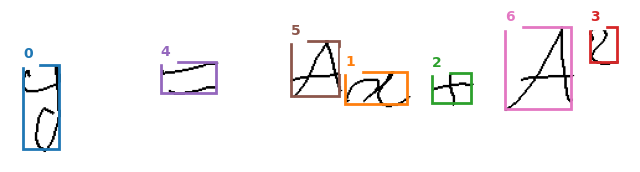

Test sur dataset[0]


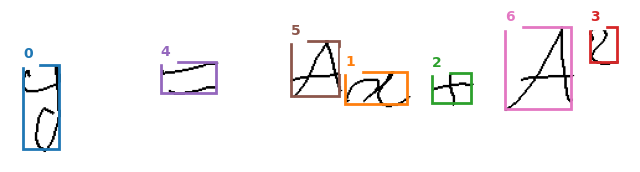

Test sur train_subset[0]


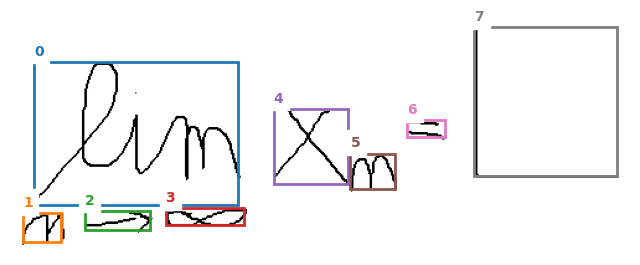

In [11]:
show_raw_boxes(dataset, 0)
show_image(dataset, 0, debug=True)

# Cellule de test pour show_image_with_boxes
try:
    print("Test sur dataset[0]")
    show_image(dataset, 0, debug=False)
except Exception as e:
    print("Erreur sur dataset:", e)

# Si vous utilisez un Subset (train_subset), tester aussi :
try:
    print("Test sur train_subset[0]")
    show_image(train_subset, 0, debug=False)
except Exception as e:
    print("Erreur sur train_subset:", e)


### data

In [30]:
class NetMLP(nn.Module):
    def __init__(self, hiddencells=100, out_classes=5):
        super(NetMLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32, hiddencells)
        self.fc2 = nn.Linear(hiddencells, out_classes)
    def forward(self, x):
        x = x.view(-1, 32 * 32)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # logits for CrossEntropyLoss

# transform for MLP (32x32 grayscale)
mlp_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])


In [31]:
# small dataset for quick test (use full dataset if desired)
dataset_mlp = CROHMEDataset(root=root, transform=mlp_transform, meta_classes=True)

# split
n = len(dataset_mlp)
train_n = int(0.8 * n)
val_n = int(0.1 * n)
test_n = n - train_n - val_n
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset_mlp, [train_n, val_n, test_n], generator=torch.Generator().manual_seed(42))

def collate_for_mlp(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)            # (B, C, H, W)
    labels = []
    for t in targets:
        labs = t.get("labels", None)
        if labs is None or len(labs) == 0:
            labels.append(0)
        else:
            v = labs[0]
            labels.append(int(v.item()) if torch.is_tensor(v) else int(v))
    labels = torch.tensor(labels, dtype=torch.long)
    return images, labels

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_for_mlp, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, collate_fn=collate_for_mlp, num_workers=0)



### training loop

In [32]:
def fullTraining(net,
                 trainloader,
                 validationloader,
                 validationset,
                 optimizer,
                 criterion = nn.CrossEntropyLoss(),
                 minibatchsize = 32,
                 num_epochs = 5,
                 print_every = 10,
                 print_epoch = True,
                 savename = ''):
    """Entraîne le réseau de neurones en entrée sur les datasets d'entraînement et de validation"""

    # Definition of arrays to store the results and draw the learning curves
    val_err_array = np.array([])
    train_err_array = np.array([])
    nb_sample_array = np.array([])

    # best system results
    best_val_loss = float('inf')
    best_nb_sample = 0
    running_loss = 0.0
    best_model =  copy.deepcopy(net)

    nb_used_sample = 0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = time.time()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) # if possible, move them to GPU

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # count how many samples have been used during the training
            nb_used_sample += minibatchsize
            # print/save statistics
            running_loss += loss.item()
            if nb_used_sample % (print_every * minibatchsize) == 0:    # print every ""print_every"" mini-batches
                train_err = (running_loss / (print_every * minibatchsize))
                print('Epoch %d batch %5d ' % (epoch + 1, i + 1))
                print('Train loss : %.3f' % train_err)
                running_loss = 0.0
                #evaluation on validation set
                totalValLoss = 0.0
                with torch.no_grad():
                    for data in validationloader:
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criterion(outputs, labels)
                        totalValLoss += loss.item()
                val_err = (totalValLoss / len(validationset))
                print('Validation loss mean : %.3f' % val_err)
                train_err_array = np.append(train_err_array, train_err)
                val_err_array = np.append(val_err_array, val_err)
                nb_sample_array = np.append(nb_sample_array, nb_used_sample)

                # save the model only when loss is better
                if val_err < best_val_loss:
                    best_val_loss = val_err
                    best_model = copy.deepcopy(net)
        if print_epoch :
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))

    print('Finished Training')

    # save the best model
    if savename != '':
        torch.save(best_model.state_dict(), f"./best_model_{savename}.nn")

    # learning curves
    fig, ax = plt.subplots()
    ax.set_xlabel('epoch')
    ax.set_ylabel('val (blue)/ train (red) LOSS')
    ax.set_title('Digit classifier')
    ax.plot(nb_sample_array.tolist(), val_err_array.tolist(), 'b', nb_sample_array.tolist(), train_err_array.tolist(), 'r')

    # trained network
    return best_model, fig


----- Initialisation of the neural network -----
----- Training of the neural network -----
Epoch 1 of 25 took 7.123s
Epoch 1 of 25 took 7.123s
Epoch 2 batch   250 
Train loss : 0.033
Epoch 2 batch   250 
Train loss : 0.033
Validation loss mean : 0.034
Epoch 2 of 25 took 7.957s
Validation loss mean : 0.034
Epoch 2 of 25 took 7.957s
Epoch 3 of 25 took 6.948s
Epoch 3 of 25 took 6.948s
Epoch 4 batch   250 
Train loss : 0.033
Epoch 4 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 4 of 25 took 7.805s
Validation loss mean : 0.033
Epoch 4 of 25 took 7.805s
Epoch 5 of 25 took 6.961s
Epoch 5 of 25 took 6.961s
Epoch 6 batch   250 
Train loss : 0.033
Epoch 6 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 6 of 25 took 7.858s
Validation loss mean : 0.033
Epoch 6 of 25 took 7.858s
Epoch 7 of 25 took 6.981s
Epoch 7 of 25 took 6.981s
Epoch 8 batch   250 
Train loss : 0.033
Epoch 8 batch   250 
Train loss : 0.033
Validation loss mean : 0.033
Epoch 8 of 25 took 7.

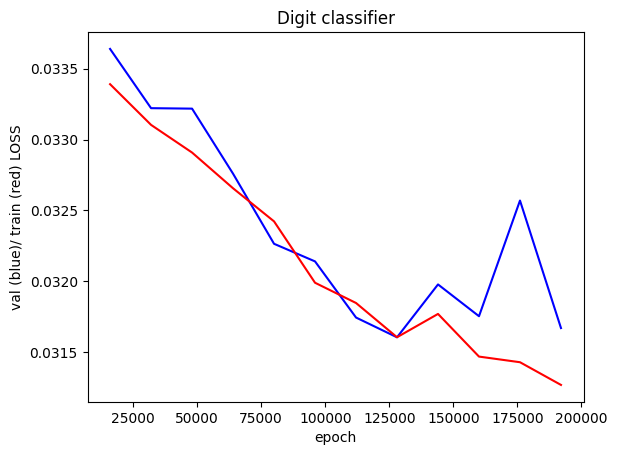

----- Evaluation of the neural network on the test set -----
Accuracy of the network on the test images: 57.20 %
Accuracy of alpha : 29.64 % (91/307)
Accuracy of digit : 0.00 % (0/137)
Accuracy of operator : 0.00 % (0/24)
Accuracy of other : 90.41 % (481/532)
No background sample
Accuracy of the network on the test images: 57.20 %
Accuracy of alpha : 29.64 % (91/307)
Accuracy of digit : 0.00 % (0/137)
Accuracy of operator : 0.00 % (0/24)
Accuracy of other : 90.41 % (481/532)
No background sample


In [34]:
##### Neural network #####

print("----- Initialisation of the neural network -----")
net = NetMLP(hiddencells=100, out_classes=5)  # 4 meta-classes
net.to(device) # move it to GPU or CPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.01)




##### Training #####

print("----- Training of the neural network -----")
best_model, fig = fullTraining(
    net = net,
    trainloader = train_loader,
    validationloader = val_loader,
    validationset = val_ds,
    optimizer = optimizer,
    criterion = criterion,
    minibatchsize = batch_size,
    num_epochs = 25,
    print_every = 500,
    print_epoch = True,
    savename = 'mlp_crohme')

display(fig)
plt.close(fig)




##### Test of the trained neural network #####

print("----- Evaluation of the neural network on the test set -----")
correct, total, class_correct, class_total, all_preds, all_labels = accuracy_test(
    net,
    test_loader,
    minibatchsize = batch_size,
    print_acc = True,
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))




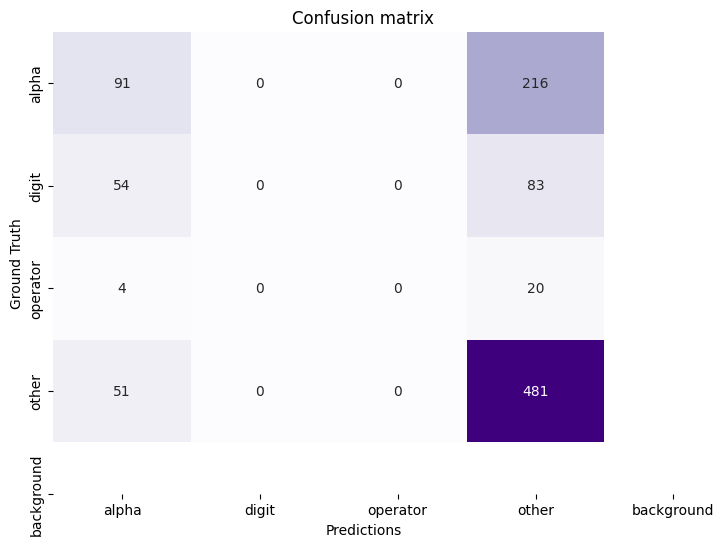

In [35]:
print_matrix(all_labels, all_preds, classes=['alpha', 'digit', 'operator', 'other', 'background'])